In [1]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

# TODO:
# * Short the legend following the color code

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'

In [2]:
scen_labels_ = pd.read_csv('cost_scenario_labels.csv') 
tech_labels_ = pd.read_csv('technology_labels.csv') 

In [160]:
# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_dispatch(scen_labels_):

    # Load energy dispatch table and process data from database
    def __load_dispatch_from_csv(df_, scenario, zone):
        
        df_ = df_[['period', 'timepoint', 'technology', 'load_zone', 'power_mw']]
            
        df_ = df_.groupby(['period', 
                           'timepoint',
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                
        return df_
        
    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario, zone):
                
        df_1_               = df_[['period', 'timepoint', 'load_zone', 'overgeneration_mw']].copy()
        df_1_['technology'] = 'Curtailment'                
        df_1_               = df_1_.rename(columns = {'overgeneration_mw': 'power_mw'})

        df_2_               = df_[['period',  'timepoint', 'load_zone', 'unserved_energy_mw']].copy()
        df_2_['technology'] = 'Shedding'                 
        df_2_               = df_2_.rename(columns = {'unserved_energy_mw': 'power_mw'})

        df_ = pd.concat([df_1_, df_2_], axis = 0)
            
        df_ = df_.groupby(['period', 
                           'timepoint', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                                  
        return df_

    def __load_tx_losses_from_csv(df_, scenario, zone):
        
        df_['transmission_losses_lz_to']   = - df_['transmission_losses_lz_to'] 
        df_['transmission_losses_lz_from'] = - df_['transmission_losses_lz_from']

        df_1_               = df_[['period', 'timepoint', 'load_zone_to', 'transmission_losses_lz_to']].copy()
        df_1_['technology'] = 'Tx_Losses'
        df_1_               = df_1_.rename(columns = {'transmission_losses_lz_to': 'power_mw', 
                                                      'load_zone_to': 'load_zone'})

        df_2_               = df_[['period',  'timepoint', 'load_zone_from', 'transmission_losses_lz_from']].copy()
        df_2_['technology'] = 'Tx_Losses'
        df_2_               = df_2_.rename(columns = {'transmission_losses_lz_from': 'power_mw',
                                                      'load_zone_from': 'load_zone'})
        
        df_3_ = df_[['period', 'timepoint', 'load_zone_to', 'transmission_flow_mw']].copy()
        df_3_ = df_3_.rename(columns = {'transmission_flow_mw': 'power_mw',
                                        'load_zone_to': 'load_zone'})

        df_3_.loc[df_3_['power_mw'] >= 0., 'technology'] = 'Import'
        df_3_.loc[df_3_['power_mw'] < 0., 'technology']  = 'Export'

        
        df_4_ = df_[['period', 'timepoint', 'load_zone_from', 'transmission_flow_mw']].copy()
        df_4_ = df_4_.rename(columns = {'transmission_flow_mw': 'power_mw',
                                        'load_zone_from': 'load_zone'})

        df_4_['power_mw'] = - df_4_['power_mw']

        df_4_.loc[df_4_['power_mw'] >= 0., 'technology'] = 'Import'
        df_4_.loc[df_4_['power_mw'] < 0., 'technology']  = 'Export'

        df_ = pd.concat([df_1_, df_2_, df_3_, df_4_], axis = 0)
        
        df_ = df_.groupby(['period', 
                           'timepoint',
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)

        df_['scenario'] = scenario
        
        return df_
        
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone, path in zip(scen_labels_['scenario'], scen_labels_['zone'], scen_labels_['path']):
        print(scen, path)
        
        dir_name   = r'{}/{}'.format(path, scen)
        dispatch_  = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        demand_    = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_tx_losses_from_csv(tx_losses_, scen, zone)]
        dfs_ += [__load_demand_from_csv(demand_, scen, zone)]
        dfs_ += [__load_dispatch_from_csv(dispatch_, scen, zone)]
        break
        
    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

def _load_demand(scen_labels_):
    
    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario):
  
        df_               = df_[['period', 'timepoint', 'load_zone', 'static_load_mw']].copy()
        df_               = df_.rename(columns = {'static_load_mw': 'power_mw'})
        df_['technology'] = 'Demand'                 
        df_               = df_
        df_               = df_.groupby(['period', 
                                         'timepoint',
                                         'technology', 
                                         'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                                  
        return df_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name = r'{}/{}'.format(path, scen)
        demand_  = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_demand_from_csv(demand_, scen)]
        break
    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

demand_ = _load_demand(scen_labels_)

dispatch_ = _load_dispatch(scen_labels_)
#dispatch_ = dispatch_.groupby(['period', 'timepoint']).agg({'power_mw': 'sum'}).reset_index(drop = False)


VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


In [166]:
def _group_dispatch_technologies(df_, tech_labels_):

    for group in tech_labels_['group'].unique():
        idx_ = tech_labels_['group'] == group
        idx_ = df_['technology'].isin(tech_labels_.loc[idx_, 'technology'])
        df_.loc[idx_, 'technology'] = group
        
    df_ = df_.groupby(['period', 
                       'timepoint', 
                       'technology', 
                       'load_zone', 
                       'scenario']).agg({'power_mw': 'sum'})

    return df_.reset_index(drop = False)

grouped_dispatch_ = _group_dispatch_technologies(dispatch_, tech_labels_)
print(grouped_dispatch_)

        period   timepoint technology       load_zone  \
0         2020  2020040101    Battery  Andhra_Pradesh   
1         2020  2020040101    Battery           Assam   
2         2020  2020040101    Battery           Bihar   
3         2020  2020040101    Battery    Chhattisgarh   
4         2020  2020040101    Battery           Delhi   
...        ...         ...        ...             ...   
793784    2050  2051030224       Wind       Rajasthan   
793785    2050  2051030224       Wind      Tamil_Nadu   
793786    2050  2051030224       Wind       Telangana   
793787    2050  2051030224       Wind   Uttar_Pradesh   
793788    2050  2051030224       Wind     West_Bengal   

                                                 scenario      power_mw  
0       VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...      0.000000  
1       VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...      0.000000  
2       VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...      0.000000  
3       VRElow_STlo

In [174]:
# Plot energy dispatch for a given day
def _plot_zone_energy_dispatch_production(ax, df_1_, df_2_, scen_labels_, tech_labels_, scen, period, load_zone,
                                          units  = 1e3,
                                          legend = False):

    all_colors_ = []
    legend_     = []
    ys_         = []
    
    label = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]
    
    zone  = load_zone.replace('_', ' ')
    title = f'{label} - {zone}'
    
    x_ = np.sort(df_1_.loc[df_1_['period'] == period, 'timepoint'].unique().astype(int)).astype(str)

    for tech in tech_labels_['group'].unique():

        idx_ = (df_1_['technology'] == tech) & (df_1_['scenario'] == scen) 
        idx_ = idx_ & (df_1_['load_zone'] == load_zone) & (df_1_['period'] == period)
        x_p_ = df_1_.loc[idx_, 'timepoint'].to_numpy().astype(int).astype(str)
        y_   = df_1_.loc[idx_, 'power_mw'].to_numpy()/units
        idx_ = y_ > 0.
        
        if idx_.sum() > 0.:
            
            color = tech_labels_.loc[tech_labels_['group']== tech, 'group_color'].to_numpy()[0]
            y_p_  = np.zeros((x_.shape[0],))
            x_p_  = x_p_[idx_]
            y_    = y_[idx_]
            
            for x_p in x_p_:
                if (x_ == x_p).sum() == 1:
                    y_p_[x_ == x_p] = y_[x_p_ == x_p]

            all_colors_.append(color)
            ys_.append(y_p_)

            ax.bar(0., 0., 0., bottom    = 0. ,
                               label     = tech,
                               color     = color,
                               lw        = 0.,
                               edgecolor = "None", 
                               zorder    = 10)
            
    ax.stackplot(x_, np.vstack(ys_), colors = all_colors_, 
                                     zorder = 10, 
                                     lw     = 0.)

    all_colors_ = []
    ys_         = []
    for tech in tech_labels_['group'].unique():

        idx_ = (df_1_['technology'] == tech) & (df_1_['scenario'] == scen) 
        idx_ = idx_ & (df_1_['load_zone'] == load_zone) & (df_1_['period'] == period)
        x_p_ = df_1_.loc[idx_, 'timepoint'].to_numpy().astype(int).astype(str)
        y_   = df_1_.loc[idx_, 'power_mw'].to_numpy()/units
        idx_ = y_ < 0.
        
        if idx_.sum() > 0.:

            color = tech_labels_.loc[tech_labels_['group']== tech, 'group_color'].to_numpy()[0]
            y_p_  = np.zeros((x_.shape[0],))
            x_p_  = x_p_[idx_]
            y_    = y_[idx_]

            for x_p in x_p_:
                if (x_ == x_p).sum() == 1:
                    y_p_[x_ == x_p] = y_[x_p_ == x_p]
            
            all_colors_.append(color)
            ys_.append(y_p_)

    ax.bar(0., 0., 0., bottom    = 0. ,
                       label     = 'Export',
                       color     = '#55A182',
                       lw        = 0.,
                       hatch     = 'xx', 
                       edgecolor = 'lightgray', 
                       zorder    = 10)

    ax.bar(0., 0., 0., bottom    = 0. ,
                       label     = 'Charge',
                       color     = 'None',
                       lw        = 0.,
                       hatch     = 'xx', 
                       edgecolor = 'lightgray', 
                       zorder    = 10)

    if len(ys_) > 0.:    
        ax.stackplot(x_, np.vstack(ys_), colors    = all_colors_, 
                                         zorder    = 10, 
                                         hatch     = 'xx', 
                                         edgecolor = 'lightgrey', 
                                         lw        = 0.)
        
    idx_  = (df_2_['technology'] == 'Demand') & (df_2_['scenario'] == scen)
    idx_  = idx_ & (df_2_['load_zone'] == load_zone) & (df_2_['period'] == period)
    load_ = df_2_.loc[idx_, 'power_mw'].to_numpy()/units
    
    ax.plot(x_, load_, color     = 'r', 
                       linestyle = '--', 
                       label     = 'Demand',
                       lw        = 1.75, 
                       alpha     = 1., 
                       zorder    = 11)

    ax.set_ylabel(r'Energy (GWh)', fontsize = 16)
    ax.set_xticks(x_[::24], [x[:-2] for x in x_][::24], rotation = 90)
    ax.xaxis.set_tick_params(labelsize = 12)
    ax.yaxis.set_tick_params(labelsize = 12)

    ax.axhline(0, linewidth = .5, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    ax.set_xlim(x_[0], x_[-1])

    ax.set_title(title, fontsize = 18)
    
    ax.grid()

    if legend:
        ax.legend(loc            = 'center left', 
                  bbox_to_anchor = (1., 0.475),
                  frameon        = False,
                  prop           = {'size': 14})

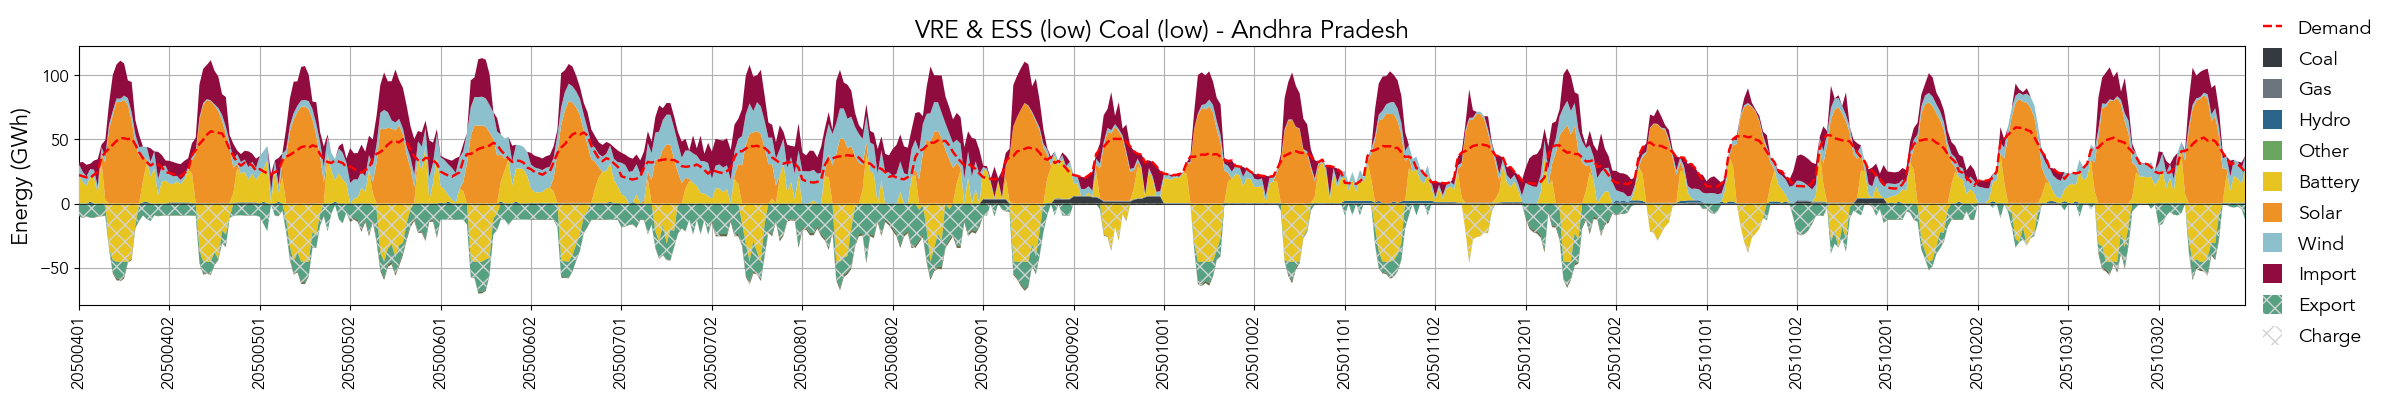

In [175]:
fig = plt.figure(figsize = (24, 4))
_ax = plt.subplot(111)

scen   = 'VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid'
period = 2050
zone   = 'Andhra_Pradesh'

periods_ = np.sort(demand_['period'].unique())

# Plot energy dispatch for a given day
_plot_zone_energy_dispatch_production(_ax, grouped_dispatch_, demand_, scen_labels_, tech_labels_, 
                                      scen, period, zone, 
                                      legend = True)
    
plt.tight_layout()

plt.savefig(path_to_images + f'/{zone}-{scen}-dispath_plot.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()